# PyTomography Recon Notebook

2 Sections
1. Proposed I/O functionality to add to PyTomography
2. Image reconstruction

I've added TODO comments for things that David/Luke can work on.

In [1]:
import pytomography
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from pytomography.io.SPECT import dicom
from pathlib import Path
from pytomography.metadata.SPECT import SPECTObjectMeta, SPECTProjMeta
import os
import numpy as np
from pytomography.io.SPECT import dicom
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
import matplotlib.pyplot as plt
import pydicom
import shutil

# Part 1: Proposed GATE I/O Functionality

This function already exists in PyTomography, but is updated below to account for the fact that multiple values can be stored on the same line of a header file (e.g. ElementSpacing = ...)

In [2]:
def get_header_value(
    list_of_attributes: list[str],
    header: str,
    dtype: type = np.float32,
    split_substr = ':=',
    split_idx = -1,
    return_all = False
    ) -> float|str|int:
    header = header.replace('[', r'\[').replace(']',r'\]').replace('(', r'\(').replace(')', r'\)')
    y = np.vectorize(lambda y, x: bool(re.compile(x).search(y)))
    selection = y(list_of_attributes, header).astype(bool)
    lines = list_of_attributes[selection]
    if len(lines)==0:
        return False
    values = []
    for i, line in enumerate(lines):
        if dtype == np.float32:
            values.append(np.float32(line.replace('\n', '').split(split_substr)[split_idx]))
        elif dtype == str:
            values.append(line.replace('\n', '').split(split_substr)[split_idx].replace(' ', ''))
        elif dtype == int:
            values.append(int(line.replace('\n', '').split(split_substr)[split_idx].replace(' ', '')))
        elif dtype == list:
            values.append(line.replace('\n', '').split(split_substr)[split_idx].lstrip().split(' '))
        if not(return_all):
            return values[0]
    return values

These are the functions we propose to add to a new GATE I/O module for PyTomography. 

In [3]:
def get_metadata(headerfile):
    with open(headerfile) as f:
        headerdata = f.readlines()
    headerdata = np.array(headerdata)
    # Get projection spacing
    projection_spacing = get_header_value(headerdata, 'ElementSpacing', list, split_substr = '=')
    projection_spacing = [float(x) for x in projection_spacing]
    dx, dz = projection_spacing[0], projection_spacing[2]

    # Get dimenisions
    projection_dimensions = get_header_value(headerdata, 'DimSize', list, split_substr = '=')
    projection_dimensions = [int(x) for x in projection_dimensions]
    Nx, Nz, Nangles = projection_dimensions[0], projection_dimensions[1], projection_dimensions[2]

    # TODO: (David) is there a way to add these to the headers?
    start_angle = 0
    extent_of_rotation = 360
    direction = 'CCW'

    angles = np.linspace(-start_angle, -start_angle+extent_of_rotation, Nangles, endpoint=False)
    if direction=='CW':
        angles = -angles % 360
        
    # TODO: (David)  can we add radial positions to headers as well?
    radius_constant = 16
    radii = np.ones(Nangles)*radius_constant

    shape_obj = (Nx, Nx, Nz)
    dr_obj = (dx, dx, dz)

    object_meta = SPECTObjectMeta(dr_obj,shape_obj)
    proj_meta = SPECTProjMeta((Nx, Nz), (dx,dz), angles, radii)
    return object_meta, proj_meta

def get_projections(headerfile):
    with open(headerfile) as f:
        headerdata = f.readlines()
    headerdata = np.array(headerdata)
    object_meta, proj_meta = get_metadata(headerfile)
    Nangle, Nx, Nz = proj_meta.shape
    imagefile = get_header_value(headerdata, 'ElementDataFile', str, split_substr = '=')
    projections = np.fromfile(os.path.join(str(Path(headerfile).parent), imagefile), dtype=np.float32).reshape((Nangle,Nx,Nz))
    projections = torch.tensor(projections.copy()).to(pytomography.device).swapaxes(1,2)
    # TODO Luke: Check orientation of projections
    return projections

# Part 2: PyTomography Reconstruction

In [4]:
# Change these to where downloaded
headerfile = '/home/gpuvmadm/spect_pytomography/output/03_iec_arf_200sec/projections_ene_1.mhd'
datafile = '/home/gpuvmadm/spect_pytomography/output/03_iec_arf_200sec/projections_ene_1.raw'

Obtain projecitons and metadata

In [5]:
object_meta, proj_meta = get_metadata(headerfile)
projections = get_projections(headerfile)

Attenuation correction:

In [6]:
# TODO: (David) can we add the attenuation map as one of the data files so we can perform attenuation correction? I'll also need to write a data loader for this. I leave attenuation correction out for now

PSF modeling:

In [7]:
# TODO (David) is there a way of providing the collimator code so we can automatically get the PSF meta? Right now I use the dicom functionality with the corresponding code
collimator_name = 'SY-LEHR' # assuming this is the collimator
energy_kev = 140.5 #keV
intrinsic_resolution=0.38 #mm
psf_meta = dicom.get_psfmeta_from_scanner_params(
    collimator_name,
    energy_kev,
    intrinsic_resolution=intrinsic_resolution
)
psf_transform = SPECTPSFTransform(psf_meta)

Scatter correction

In [8]:
# TODO (David) can you add a lower energy window to the Tc-99m data so we can do dual energy window scatter correction? SIMIND stores seperate energy windows using seperate header/data files

Build system matrix

In [9]:
system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta)
likelihood = PoissonLogLikelihood(system_matrix, projections)
reconstruction_algorithm = OSEM(likelihood)
reconstructed_object = reconstruction_algorithm(n_iters=4, n_subsets=8)

Show reconstruction:

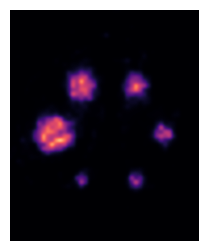

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(reconstructed_object[:,:,70].cpu().T, cmap='magma', origin='lower', interpolation='Gaussian')
plt.xlim(40,85)
plt.ylim(30,85)
plt.axis('off')
plt.show()